Author: K. Geil

Date: 03/2023

Description: convert monthly rst files and elevation to netcdf, create an admin mask


## Set up

In [2]:
import numpy as np
import glob

import rioxarray as rio
import xarray as xr

from natsort import natsorted 
# import dask.array as da

import matplotlib.pyplot as plt

import pandas as pd


In [11]:
# notebook directory location
work_dir='/work/hpc/users/kerrie/UN_FAO/repos/pyAEZ_data_prep/' # orion

# web link to notebook
nb_link='https://github.com/kerriegeil/pyAEZ_data_prep/blob/main/global/02_rst_to_nc.ipynb'

# data directory location
# data_dir='/work/hpc/users/kerrie/UN_FAO/data/orig/DataDownload03152023/' # orion
data_dir='/work/hpc/datasets/un_fao/'
# srad_dir='/work/hpc/users/kerrie/UN_FAO/data/from_Gunther/' # orion
srad_dir='/work/hpc/datasets/un_fao/gaez/global_1980/monthly/tif/'

elevfile=data_dir+'pyaez/static/rst/ALOSdem5m_fill.rst'

# output data file directory
# out_dir='/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/monthly/'
out_dir='/work/hpc/datasets/un_fao/pyaez/global_1980/monthly/netcdf/'

# linux path of project directory (to include in file metadata)
# source_dir='/gri/projects/UN_FAO/'

# input file name components
dataset='AgERA5'
experiment='Hist'
year='1980'
months=[str(x).rjust(2,'0') for x in np.arange(1,13)]
gridsize='5m'
file_ext_d='.pxv'
file_exts_m=['.rst','.rdc']
variables=['Precip','Srad','Tmax-2m','Tmin-2m','Vapr','Wind-10m','Elevation','Mask']

# some constants
# landfrac_thresh=2500
month_int=np.arange(1,13)

# metadata for output data files
timeattrs={'standard_name':'time','long_name':'time','axis':'T'}
time_encoding={'calendar':'standard','units':'days since 1900-01-01 00:00:00','_FillValue':None}
latattrs={'standard_name':'latitude','long_name':'latitude','units':'degrees_north','axis':'Y'}
lat_encoding={'_FillValue':None}
lonattrs={'standard_name':'longitude','long_name':'longitude','units':'degrees_east','axis':'X'}
lon_encoding={'_FillValue':None}
var_encoding = {'zlib':True,'dtype':'float32'}

In [4]:
# create middle of the month datetimes
# these will be assigned to the time dim of climate data
time_ms=pd.date_range(year+'-01-01',year+'-12-31',freq='MS')
time_me=pd.date_range(year+'-01-01',year+'-12-31',freq='M')+pd.Timedelta('1d')
offset=(time_me-time_ms)/2
time=time_me-offset
# time

## Define functions

In [12]:
# function for getting a list of data files
def getFilelist(var,ext):
    if (var=='Elevation'):
        filelist=[elevfile]
#     elif (var=='Mask'):
#         filelist=[data_dir+'pyaez/static/rst/ALOSmask5m_fill.rst']     
#         filelist=[data_dir+'gaez/static/mask_2287408_5m.nc'] 
    elif (var=='Srad'):
        filename=var+'_'+dataset+'_'+experiment+'_'+year+'_*_'+gridsize+ext
        filelist=natsorted(glob.glob(srad_dir+filename))
    else:
        filename=var+'_'+dataset+'_'+experiment+'_'+year+'_*_'+gridsize+ext
        filelist=natsorted(glob.glob(data_dir+'pyaez/global_1980/monthly/rst/'+filename))

    return filelist

In [6]:
# function to load data into xarray dataset
def loadData(filelist):
    if (len(filelist)>1):
        time_ms=pd.date_range(year+'-01-01',year+'-12-31',freq='MS')
        time_me=pd.date_range(year+'-01-01',year+'-12-31',freq='M')+pd.Timedelta('1d')
        offset=(time_me-time_ms)/2
        time=time_me-offset

        data=[]
        for t,f in zip(time,filelist):
            d=xr.open_dataset(f,engine='rasterio')
            d=d.rename({'band':'time'})
            d.coords['time']=[t]
            data.append(d)
        ds=xr.combine_by_coords(data) 
#         del ds.band
    else:
        if 'mask' in filelist[0]:
            ds=xr.open_dataset(filelist[0])
        else:
            ds=xr.open_dataset(filelist[0],engine='rasterio').squeeze() 
            del ds.coords['band']

    if 'y' in list(ds.coords): 
        ds['y']=ds['y'].astype('float32')
    if 'x' in list(ds.coords):
        ds['x']=ds['x'].astype('float32')        
    return ds

## Create binary admin mask


In [32]:
# use one of the monthly data files to create a mask because 
# the ALOS mask, daily dev file, and monthly files all have a different number of grids with data present

filelist=[data_dir+'pyaez/global_1980/monthly/rst/Wind-10m_AgERA5_Hist_1980_01_5m.rst']
ds=loadData(filelist)

vname='admin_mask'

# rename variable and dimensions
ds=ds.rename({'x':'lon','y':'lat','band_data':vname})

# create binary mask
ds[vname]=xr.where(ds[vname]>=0,1,0)
ds[vname]=xr.where(ds.lat<-60,0,ds[vname]) # eliminate antarctica
ds[vname]=ds[vname].astype('int32')

# variable/coordinate metadata
varattrs={'standard_name':'admin_mask','long_name':'mask','units':'unitless','description':'binary administrative mask'}
ds[vname].attrs=varattrs
ds['lat'].attrs=latattrs
ds['lon'].attrs=lonattrs

# global attributes
ds=ds.assign_attrs({'source_data':filelist[0],
                    'source_code':nb_link})

ds

<xarray.Dataset>
Dimensions:      (lon: 4320, lat: 2160)
Coordinates:
  * lon          (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat          (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
    spatial_ref  int64 0
Data variables:
    admin_mask   (lat, lon) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    source_data:  /work/hpc/datasets/un_fao/pyaez/global_1980/monthly/rst/Win...
    source_code:  https://github.com/kerriegeil/pyAEZ_data_prep/blob/main/glo...

In [33]:
# save the spatial ref
spatial_ref=ds.spatial_ref

# save admin_mask
admin_mask=ds.admin_mask

In [34]:
# test for values other than 0,1
print(np.unique(admin_mask))

# test for correct mask
ngrids=admin_mask.data.sum()
print(ngrids)

[0 1]
2268708


In [35]:
# write to file
ds.to_netcdf(data_dir+'pyaez/static/netcdf/'+vname+'_'+str(ngrids)+'_5m.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      vname:{'zlib':True,'dtype':'int32'}})

# Output elevation to netcdf

In [13]:
vname='Elevation'

filelist=getFilelist(vname,'.rst')
ds=loadData(filelist)

# rename variable and dimensions
ds=ds.rename({'x':'lon','y':'lat','band_data':vname})

# apply mask 
ds=ds.where(admin_mask>0)

# variable/coordinate metadata
varattrs={'standard_name':'Elevation',
          'long_name':'Elevation',
          'units':'m'}
ds[vname].attrs=varattrs
ds['lat'].attrs=latattrs
ds['lon'].attrs=lonattrs

# global attributes
ds=ds.assign_attrs({'source_data':elevfile,
                    'source_code':nb_link})

ds

<xarray.Dataset>
Dimensions:      (lat: 2160, lon: 4320)
Coordinates:
  * lon          (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat          (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
    spatial_ref  int64 0
Data variables:
    Elevation    (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    source_data:  /work/hpc/datasets/un_fao/pyaez/static/rst/ALOSdem5m_fill.rst
    source_code:  https://github.com/kerriegeil/pyAEZ_data_prep/blob/main/glo...

In [23]:
np.unique(ds.Elevation)

array([-415., -400., -395., ..., 6465., 6498.,   nan], dtype=float32)

no values have decimals, is there a conversion factor that should be used here?

In [18]:
# test for negatives
# does not apply here, elev can be below 0

# test for correct mask
ngrids=xr.where(np.isfinite(test),1,0).data.sum()
print(ngrids)

2268708


In [27]:
# write to file
ds.to_netcdf(data_dir+'pyaez/static/netcdf/'+vname+'_'+str(ngrids)+'_5m.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      vname:{'zlib':True,'dtype':'float32'}})

# Output monthly variables to netcdf

### 10m Wind

In [28]:
vname='Wind-10m'

filelist=getFilelist(vname,'.rst')
ds=loadData(filelist)

# fix the spatial_ref, we don't want it as an array
del ds['spatial_ref']
ds=ds.assign_coords({'spatial_ref':spatial_ref})

# rename variable and dimensions
ds=ds.rename({'x':'lon','y':'lat','band_data':vname})

# apply mask 
ds=ds.where(admin_mask>0)

# variable/coordinate metadata
varattrs={'standard_name':'Wind-10m',
          'long_name':'10m Wind Speed',
          'units':'m/s',
          'description':'monthly mean wind speed at 10m above surface'}
ds['Wind-10m'].attrs=varattrs
ds['lat'].attrs=latattrs
ds['lon'].attrs=lonattrs
ds['time'].attrs=timeattrs

# global attributes
ds=ds.assign_attrs({'source_data':data_dir+'pyaez/global_1980/monthly/rst/Wind-10m_AgERA5_Hist_1980_*_5m.rst',
                    'source_code':nb_link})

ds

<xarray.Dataset>
Dimensions:      (time: 12, lat: 2160, lon: 4320)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-16T12:00:00 ... 1980-12-16T12:...
  * lon          (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat          (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
    spatial_ref  int64 0
Data variables:
    Wind-10m     (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    source_data:  /work/hpc/datasets/un_fao/pyaez/global_1980/monthly/rst/Win...
    source_code:  https://github.com/kerriegeil/pyAEZ_data_prep/blob/main/glo...

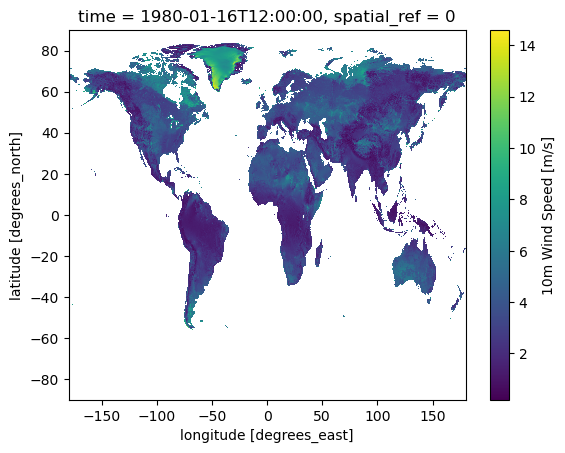

In [29]:
ds['Wind-10m'].sel(time='1980-01').plot()

In [30]:
# test for negatives
test=ds[vname][0,:,:]
testneg=xr.where(test<0,1,0)
print(testneg.sum().data)

# test for correct mask
ngrids=xr.where(np.isfinite(test),1,0)
print(ngrids.sum().data)

0
2268708


In [31]:
# write to file
ds.to_netcdf(out_dir+vname+'_monthly_1980_5m.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      vname:var_encoding})

### Short wave radiation 

In [36]:
vname='Srad'

filelist=getFilelist(vname,'.tif')
ds=loadData(filelist)

# fix the spatial_ref, we don't want it as an array
del ds['spatial_ref']
ds=ds.assign_coords({'spatial_ref':spatial_ref})

# rename variable and dimensions
ds=ds.rename({'x':'lon','y':'lat','band_data':vname})

# apply mask 
ds=ds.where(admin_mask>0)

# variable/coordinate metadata
varattrs={'standard_name':vname,
        'long_name':'surface short wave radiation down',
        'units':'J/m2/day',
        'description':'monthly mean downwelling shortwave radiation at the surface'}
ds[vname].attrs=varattrs
ds['lat'].attrs=latattrs
ds['lon'].attrs=lonattrs
ds['time'].attrs=timeattrs

# global attributes
ds=ds.assign_attrs({'source_data':srad_dir+'Srad_AgERA5_Hist_1980_*_5m.tif',
                    'source_code':nb_link})

ds

<xarray.Dataset>
Dimensions:      (time: 12, lat: 2160, lon: 4320)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-16T12:00:00 ... 1980-12-16T12:...
  * lon          (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat          (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
    spatial_ref  int64 0
Data variables:
    Srad         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    source_data:  /work/hpc/datasets/un_fao/gaez/global_1980/monthly/tif/Srad...
    source_code:  https://github.com/kerriegeil/pyAEZ_data_prep/blob/main/glo...

In [37]:
# test for negatives
test=ds[vname][0,:,:]
testneg=xr.where(test<0,1,0)
print(testneg.sum().data)

# test for correct mask
ngrids=xr.where(np.isfinite(test),1,0)
print(ngrids.sum().data)

0
2268708


In [38]:
# write to file
ds.to_netcdf(out_dir+vname+'_monthly_1980_5m.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      vname:var_encoding})

### Precip

In [39]:
vname='Precip'

filelist=getFilelist(vname,'.rst')
ds=loadData(filelist)

# fix the spatial_ref, we don't want it as an array
del ds['spatial_ref']
ds=ds.assign_coords({'spatial_ref':spatial_ref})

# rename variable and dimensions
ds=ds.rename({'x':'lon','y':'lat','band_data':vname})

# apply mask 
ds=ds.where(admin_mask>0)

# variable/coordinate metadata
varattrs={'standard_name':vname,
        'long_name':'precipitation',
        'units':'mm/month',
        'description':'monthly total accumulated precipitation'}
ds[vname].attrs=varattrs
ds['lat'].attrs=latattrs
ds['lon'].attrs=lonattrs
ds['time'].attrs=timeattrs

# global attributes
ds=ds.assign_attrs({'source_data':data_dir+'pyaez/global_1980/monthly/rst/Precip_AgERA5_Hist_1980_*_5m.rst',
                    'source_code':nb_link})

ds

<xarray.Dataset>
Dimensions:      (time: 12, lat: 2160, lon: 4320)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-16T12:00:00 ... 1980-12-16T12:...
  * lon          (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat          (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
    spatial_ref  int64 0
Data variables:
    Precip       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    source_data:  /work/hpc/datasets/un_fao/pyaez/global_1980/monthly/rst/Pre...
    source_code:  https://github.com/kerriegeil/pyAEZ_data_prep/blob/main/glo...

In [40]:
# test for negatives
test=ds[vname][0,:,:]
testneg=xr.where(test<0,1,0)
print(testneg.sum().data)

# test for correct mask
ngrids=xr.where(np.isfinite(test),1,0)
print(ngrids.sum().data)

0
2268708


In [41]:
# write to file
ds.to_netcdf(out_dir+vname+'_monthly_1980_5m.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      vname:var_encoding})

### Tmin-2m

In [42]:
vname='Tmin-2m'

filelist=getFilelist(vname,'.rst')
ds=loadData(filelist)

# fix the spatial_ref, we don't want it as an array
del ds['spatial_ref']
ds=ds.assign_coords({'spatial_ref':spatial_ref})

# rename variable and dimensions
ds=ds.rename({'x':'lon','y':'lat','band_data':vname})

# apply mask 
ds=ds.where(admin_mask>0)

# variable/coordinate metadata
varattrs={'standard_name':vname,
        'long_name':'2m minimum surface air temperature',
        'units':'degrees C',
        'description':'monthly mean minimum surface air temperature at 2m'}
ds[vname].attrs=varattrs
ds['lat'].attrs=latattrs
ds['lon'].attrs=lonattrs
ds['time'].attrs=timeattrs

# global attributes
ds=ds.assign_attrs({'source_data':data_dir+'pyaez/global_1980/monthly/rst/Tmin-2m_AgERA5_Hist_1980_*_5m.rst',
                    'source_code':nb_link})

ds

<xarray.Dataset>
Dimensions:      (time: 12, lat: 2160, lon: 4320)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-16T12:00:00 ... 1980-12-16T12:...
  * lon          (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat          (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
    spatial_ref  int64 0
Data variables:
    Tmin-2m      (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    source_data:  /work/hpc/datasets/un_fao/pyaez/global_1980/monthly/rst/Tmi...
    source_code:  https://github.com/kerriegeil/pyAEZ_data_prep/blob/main/glo...

In [43]:
# test for negatives
# not needed here

# test for correct mask
test=ds[vname][0,:,:]
ngrids=xr.where(np.isfinite(test),1,0)
print(ngrids.sum().data)

2268708


In [44]:
# write to file
ds.to_netcdf(out_dir+vname+'_monthly_1980_5m.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      vname:var_encoding})

### Tmax-2m

In [45]:
vname='Tmax-2m'

filelist=getFilelist(vname,'.rst')
ds=loadData(filelist)

# fix the spatial_ref, we don't want it as an array
del ds['spatial_ref']
ds=ds.assign_coords({'spatial_ref':spatial_ref})

# rename variable and dimensions
ds=ds.rename({'x':'lon','y':'lat','band_data':vname})

# apply mask 
ds=ds.where(admin_mask>0)

# variable/coordinate metadata
varattrs={'standard_name':vname,
        'long_name':'2m maximum surface air temperature',
        'units':'degrees C',
        'description':'monthly mean maximum surface air temperature at 2m'}
ds[vname].attrs=varattrs
ds['lat'].attrs=latattrs
ds['lon'].attrs=lonattrs
ds['time'].attrs=timeattrs

# global attributes
ds=ds.assign_attrs({'source_data':data_dir+'pyaez/global_1980/monthly/rst/Tmax-2m_AgERA5_Hist_1980_*_5m.rst',
                    'source_code':nb_link})

ds

<xarray.Dataset>
Dimensions:      (time: 12, lat: 2160, lon: 4320)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-16T12:00:00 ... 1980-12-16T12:...
  * lon          (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat          (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
    spatial_ref  int64 0
Data variables:
    Tmax-2m      (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    source_data:  /work/hpc/datasets/un_fao/pyaez/global_1980/monthly/rst/Tma...
    source_code:  https://github.com/kerriegeil/pyAEZ_data_prep/blob/main/glo...

In [46]:
# test for negatives
# not needed here

# test for correct mask
test=ds[vname][0,:,:]
ngrids=xr.where(np.isfinite(test),1,0)
print(ngrids.sum().data)

2268708


In [47]:
# write to file
ds.to_netcdf(out_dir+vname+'_monthly_1980_5m.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      vname:var_encoding})

### Vapor pressure

In [48]:
vname='Vapr'

filelist=getFilelist(vname,'.rst')
ds=loadData(filelist)

# fix the spatial_ref, we don't want it as an array
del ds['spatial_ref']
ds=ds.assign_coords({'spatial_ref':spatial_ref})

# rename variable and dimensions
ds=ds.rename({'x':'lon','y':'lat','band_data':vname})

# apply mask 
ds=ds.where(admin_mask>0)

# variable/coordinate metadata
varattrs={'standard_name':vname,
        'long_name':'vapor pressure',
        'units':'hPa',
        'description':'monthly mean vapor pressure'}
ds[vname].attrs=varattrs
ds['lat'].attrs=latattrs
ds['lon'].attrs=lonattrs
ds['time'].attrs=timeattrs

# global attributes
ds=ds.assign_attrs({'source_data':data_dir+'pyaez/global_1980/monthly/rst/Vapr_AgERA5_Hist_1980_*_5m.rst',
                    'source_code':nb_link})

ds

<xarray.Dataset>
Dimensions:      (time: 12, lat: 2160, lon: 4320)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-16T12:00:00 ... 1980-12-16T12:...
  * lon          (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat          (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
    spatial_ref  int64 0
Data variables:
    Vapr         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    source_data:  /work/hpc/datasets/un_fao/pyaez/global_1980/monthly/rst/Vap...
    source_code:  https://github.com/kerriegeil/pyAEZ_data_prep/blob/main/glo...

In [49]:
# test for negatives
test=ds[vname][0,:,:]
testneg=xr.where(test<0,1,0)
print(testneg.sum().data)

# test for correct mask
ngrids=xr.where(np.isfinite(test),1,0)
print(ngrids.sum().data)

0
2268708


In [50]:
# write to file
ds.to_netcdf(out_dir+vname+'_monthly_1980_5m.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      vname:var_encoding})

# Check netcdf files

double checking that all files open correctly and have 2268708 grids with data

In [51]:
files=natsorted(glob.glob(out_dir+'*_monthly_'+year+'_5m.nc'))
files


['/work/hpc/datasets/un_fao/pyaez/global_1980/monthly/netcdf/Precip_monthly_1980_5m.nc',
 '/work/hpc/datasets/un_fao/pyaez/global_1980/monthly/netcdf/Srad_monthly_1980_5m.nc',
 '/work/hpc/datasets/un_fao/pyaez/global_1980/monthly/netcdf/Tmax-2m_monthly_1980_5m.nc',
 '/work/hpc/datasets/un_fao/pyaez/global_1980/monthly/netcdf/Tmin-2m_monthly_1980_5m.nc',
 '/work/hpc/datasets/un_fao/pyaez/global_1980/monthly/netcdf/Vapr_monthly_1980_5m.nc',
 '/work/hpc/datasets/un_fao/pyaez/global_1980/monthly/netcdf/Wind-10m_monthly_1980_5m.nc']

In [52]:
for f in files:
    d=xr.open_dataset(f) # read a data file
    vn=list(d.keys())[0]  # get variable name
    d=xr.where(np.isfinite(d[vn].isel(time=0)),1,0)  # select one timestep and create mask
    print(vn,'has',d.sum().data,'grids with data')  # count how many grids have data

Precip has 2268708 with data
Srad has 2268708 with data
Tmax-2m has 2268708 with data
Tmin-2m has 2268708 with data
Vapr has 2268708 with data
Wind-10m has 2268708 with data


In [53]:
files=natsorted(glob.glob(data_dir+'pyaez/static/netcdf/*_5m.nc'))
files

['/work/hpc/datasets/un_fao/pyaez/static/netcdf/Elevation_2268708_5m.nc',
 '/work/hpc/datasets/un_fao/pyaez/static/netcdf/admin_mask_2268708_5m.nc']

In [60]:
for f in files:
    d=xr.open_dataset(f) # read a data file
    vn=list(d.keys())[0]  # get variable name
    if vn=='Elevation':
        d=xr.where(np.isfinite(d[vn]),1,0)  # create mask   
    elif vn=='admin_mask':
        d=d[vn]
    print(vn,'has',d.data.sum(),'grids with data')  # count how many grids have data

Elevation has 2268708 grids with data
admin_mask has 2268708 grids with data


# difference between 

where gaez daily dev files have data

and

where pyaez monthly files have data

In [61]:
ddfile=data_dir+'gaez/global_1980/dailydev/netcdf/Precip_DailyDev_1980_5m.nc'
mfile=data_dir+'pyaez/global_1980/monthly/netcdf/Precip_monthly_1980_5m.nc'

dd_var=xr.open_dataset(ddfile)['Precip'].isel(time=0).drop('time')
m_var=xr.open_dataset(mfile)['Precip'].isel(time=0).drop('time')

dd_mask=xr.where(np.isfinite(dd_var),1,0)
m_mask=xr.where(np.isfinite(m_var),1,0)
dd_mask.data.sum(),m_mask.data.sum()

(2287408, 2268708)

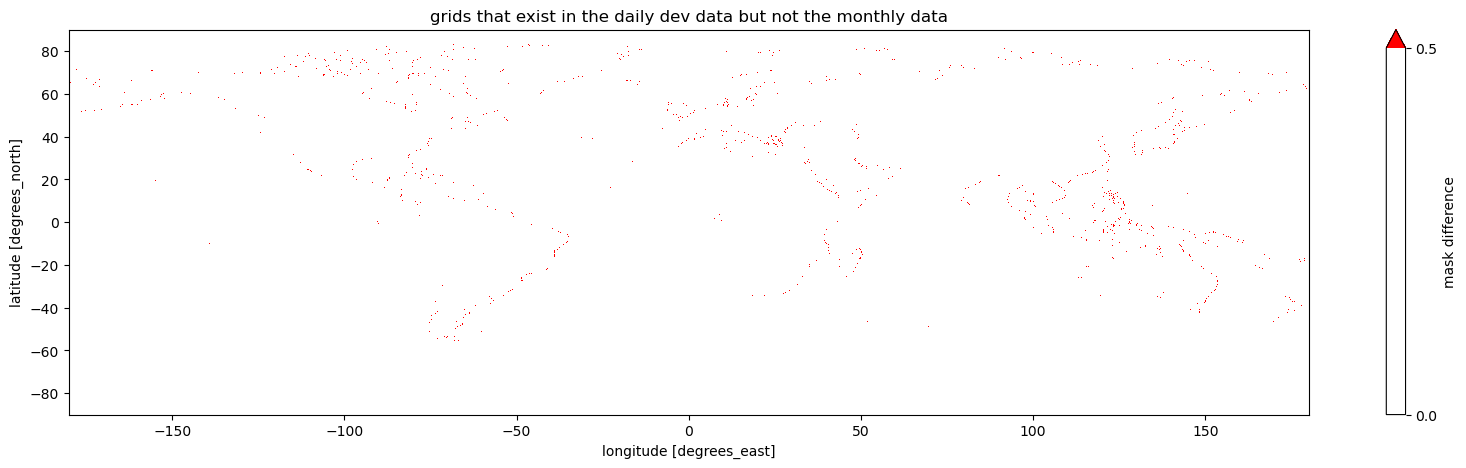

In [62]:
fig=plt.figure(figsize=(20,5))
ax=fig.add_subplot(111)
(dd_mask-m_mask).plot(colors=['white','red'],levels=[0,.5],cbar_kwargs={'label':'mask difference'})
plt.title('grids that exist in the daily dev data but not the monthly data')
plt.show()